# Bert-Based Model

In the last section we want to use BERT and leverage contextual word embeddings, following on from the last lab you've 
just done. This is an advanced part of the assignment and worth 10 marks (20%) in total. You could use your BERT-based text classifier here (instead of the CNN utterance-level classifier) and see if a pre-trained BERT language model helps. The domain difference from conversational data is one possible downside to using BERT. Explore some techniques to efficiently transfer the knowledge from conversational data and to improve model performance on DA tagging.

In [ ]:
# !pip install -r bert_requirement.txt > /dev/null

# !pip install tensorflow==2.1 > /dev/null
!pip install bert-for-tf2==0.14.4 > /dev/null
# !pip install pandas

In [ ]:
import os, glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools, random
from collections import Counter
import pdb,os,sys

In [ ]:
tf.__version__

'2.3.0'

# Data

Unzip swda.zip and drop all the extra columns keep text and tag and create three datasets in train.csv, val.csv and test.csv 

In [ ]:
df = pd.read_csv('dataset_hi_cdmx.csv')
print(df.columns,'\n',df.head(5))
df.drop(['text_id','text','ekphrasis_clean_text'],inplace=True,axis=1)
df.rename(columns={'basic_clean_text':'text'},inplace=True)
df['class'] = df['class'].astype(int)
df = df[df['text'].notna()]
df = df.sample(n=len(df), random_state=42)
dummies = pd.get_dummies(df["class"])
res = pd.concat([df, dummies], axis=1)
res['tag_arg_max'] = res.apply(lambda x: np.argmax(np.asarray(x[2:],dtype=np.float32)),axis=1)

one_hot_encoding_dict = {}
for row in res.values:
    one_hot_encoding_dict[row[0]] = row[-1]
one_hot_encoding_dict
res = res.drop(columns=['class','tag_arg_max'])
res.head()

Index(['class', 'text', 'text_id', 'ekphrasis_clean_text', 'basic_clean_text'], dtype='object') 
    class  ...                                   basic_clean_text
0      0  ...  user user user user user user user user haa ja...
1      2  ...  banti hello empowered woman , feminism gyan pe...
2      2  ...  user : user user usko chhod mjse bat tera baap...
3      2  ...  user user user punjab madarchodon knock out kh...
4      2  ...  user : agar koi bole chill maar madarchod gand...

[5 rows x 5 columns]


,text,0,1,2
1031,user chup betichod,0,0,1
1003,"user nahi dikh raha hello , lund typing one ha...",0,0,1
786,user user user user user user tere litye hello...,0,0,1
412,"user modi madarchod hello not applicable , maa...",0,0,1
1107,user mere pass randi teri janmo janmo pyas bhu...,0,0,1


In [ ]:
int(len(res)*0.80),int(len(res)*0.90)
#40304, 45342

(2548, 2866)

In [ ]:
train = res[0:2548]
val = res[2548:2866]
test = res[2866:]
train.to_csv("train.csv",index=False)
val.to_csv("val.csv",index=False)
test.to_csv("test.csv",index=False)
train = pd.read_csv("train.csv")
valid = pd.read_csv("val.csv")
test = pd.read_csv("test.csv")

In [ ]:
# train = train.append(valid).reset_index(drop=True)

In [ ]:
train.shape,test.shape,val.shape

((2548, 4), (319, 4), (318, 4))

In [ ]:
train.iloc[0]['text']

'user chup betichod'

# Get Pre-trained BERT model 

We would be using `uncased_L-12_H-768_A-12` version of BERT which has 12 layers and returns 768 hidden parameters.

In [ ]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-08-16 14:30:52--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 172.217.214.128, 108.177.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  73.5MB/s    in 5.7s    

2020-08-16 14:30:58 (67.7 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [ ]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [ ]:
os.makedirs("model")

In [ ]:
!mv uncased_L-12_H-768_A-12/ model

In [ ]:
class ProcessData:
    def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
        self.max_seq_len = 0
        self.tokenizer = tokenizer

        self.classes = classes    
        ((self.train_x, self.train_y), (self.test_x, self.test_y), (self.val_x, self.val_y)) = map(self.convert_text_to_examples, [train, test, val])

        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        print("Max Seq Len", self.max_seq_len)
        self.train_x, self.test_x, self.val_x = map(self.add_pad, [self.train_x, self.test_x, self.val_x])

    def convert_text_to_examples(self, df):
        x, y = [], []
    
        for _, row in tqdm(df.iterrows()):
            text = row['text']
            label = np.asarray(row[1:],dtype=np.float32)
            tokens = self.tokenizer.tokenize(text)
            tokens = ["[CLS]"] + tokens + ["[SEP]"]
            token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
            self.max_seq_len = max(self.max_seq_len, len(token_ids))
            x.append(token_ids)
            y.append(label)

        return np.array(x), np.array(y)

    def add_pad(self, ids):
        x = []
        for input_ids in ids:
            input_ids = list(input_ids[:min(len(input_ids), self.max_seq_len - 1)])
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.array(input_ids))
        return np.array(x)

In [ ]:
bert_model_name="uncased_L-12_H-768_A-12"
bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing of Data

Preprocessing the Data as BERT would expect.

In [ ]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [ ]:
classes = 3

data = ProcessData(train, test, tokenizer, classes, max_seq_len=128)

2548it [00:01, 1724.11it/s]
319it [00:00, 1821.50it/s]
318it [00:00, 1715.84it/s]


Max Seq Len 128


In [ ]:
len(data.test_x[0])

128

In [ ]:
from tensorflow.keras.layers import Lambda, Input, LSTM, RepeatVector, Dense, Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding, Reshape, concatenate, Conv2D, BatchNormalization, MaxPool2D, Flatten

HIDDEN_SIZE = 3
drop = 0.2
# https://github.com/kpe/bert-for-tf2
def create_model(max_seq_len, bert_ckpt_file):
    """
    Use the pre-trained BERT model over LSTM
    """
    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = None
        bert = BertModelLayer.from_params(bert_params, name="bert")
        
    input_ids = Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
    # BERT out
    bert_output = bert(input_ids)
    # to get the output dmin of form (none,128,768) --> (none,768) 
    lmd_out = Lambda(lambda seq: seq[:, 0, :])(bert_output)
    dense_1 = Dense(units=768, activation="tanh")(lmd_out)
    dropout_1 = Dropout(0.5)(dense_1)


    # LSTM expect (batch_size, timesteps, features) or (num_samples, timesteps, channels) 
    # using BERT output (none,128,768) to distribute over time(128) for LSTM
    timexx = TimeDistributed(Dense(max_seq_len))(bert_output)
    # Bidirectional 1
    b1 = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True))(timexx)
    # Bidirectional 2
    b2 = Bidirectional(LSTM(HIDDEN_SIZE))(b1)
    # Dense layer (dense_2)
    dense_2 = Dense(HIDDEN_SIZE)(b2)
    # dropout_2
    dropout_2 = Dropout(drop)(dense_2)


    # concatenate 2 final layers
    y = concatenate([dropout_1, dropout_2],axis = -1)
    # output
    out = Dense(HIDDEN_SIZE)(y)
    out = Activation('sigmoid')(out)


    model = Model(inputs=input_ids, outputs=out)
    model.build(input_shape=(None, max_seq_len))

    load_stock_weights(bert, bert_ckpt_file)
        
    return model

In [ ]:
model = create_model(data.max_seq_len, bert_ckpt_file)
model.summary()

Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f4350e3b5c0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________

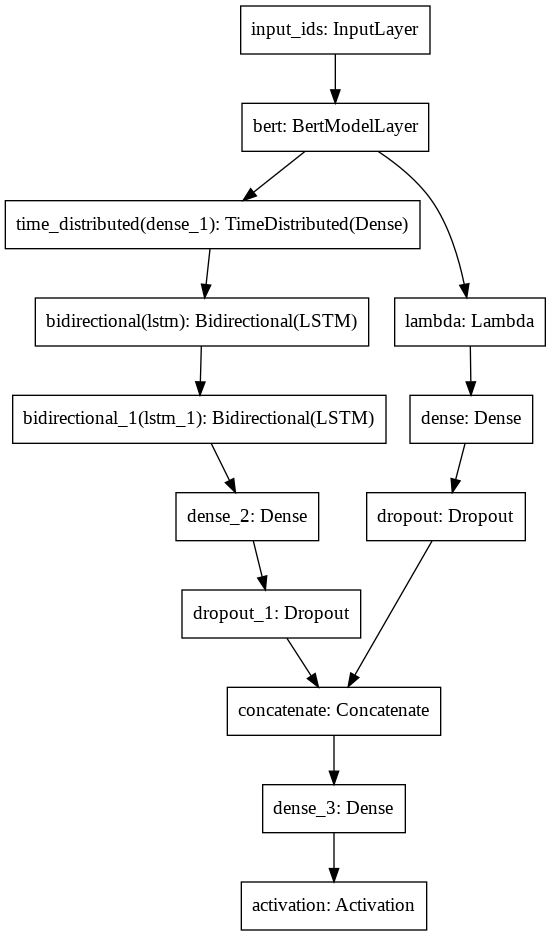

In [ ]:
plot_model(model, to_file='model.png')

From the above figure, we can understand that, the contextual information is being processed by BERT model and is being passed onto by the BiLSTM layers via timedistributed as LSTM only expect (batch_size, timesteps, features)  or (num_samples, timesteps, channels). The LSTM layers carry out the classification task and results are passed though sigmoid activation layer though which each class is decided.

## Training

In [ ]:
def train_test_input_fn(batch_size=256):
    # covert data into tensor datasets

    # Convert the inputs to a Dataset.
    dataset_train = tf.data.Dataset.from_tensor_slices((data.train_x,data.train_y))
    dataset_test = tf.data.Dataset.from_tensor_slices((data.test_x,data.test_y))
    dataset_val = tf.data.Dataset.from_tensor_slices((data.val_x,data.val_y))
    # Shuffle, repeat, and batch the examples.
    dataset_train = dataset_train.cache()
    dataset_train = dataset_train.shuffle(1000, reshuffle_each_iteration=True)
    dataset_train = dataset_train.repeat()
    dataset_train = dataset_train.batch(batch_size, drop_remainder=True)
    # dataset_test = dataset_test.cache()
    # dataset_test = dataset_test.shuffle(1000, reshuffle_each_iteration=True)
    # dataset_test = dataset_test.repeat()
    dataset_test = dataset_test.batch(batch_size, drop_remainder=True)
    dataset_val = dataset_val.cache()
    dataset_val = dataset_val.shuffle(1000, reshuffle_each_iteration=True)
    dataset_val = dataset_val.repeat()
    dataset_val = dataset_val.batch(batch_size, drop_remainder=True)
    # Return the dataset.
    return dataset_train,dataset_test,dataset_val


In [ ]:
try:
    device_name = os.environ['COLAB_TPU_ADDR']
    TPU_ADDRESS = 'grpc://' + device_name
    print('Found TPU at: {}'.format(TPU_ADDRESS))
except KeyError:
    print('TPU not found')

Found TPU at: grpc://10.114.150.74:8470


In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.experimental.TPUStrategy(resolver)


INFO:tensorflow:Initializing the TPU system: grpc://10.114.150.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.114.150.74:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
with strategy.scope():
  model = create_model(data.max_seq_len, bert_ckpt_file)
  model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'], )
# setting batch size to 121 as it perfecty divides test data length
train_dataset, test_dataset, val_dataset = train_test_input_fn(121)
checkpoint = ModelCheckpoint('bert-hi-cdmx-weights.best.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#             checkpoint = ModelCheckpoint(weights_path,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 3, verbose = 1,restore_best_weights = True)
callbacks_list = [checkpoint,earlystop]
model.fit(train_dataset,
          epochs=15,
          steps_per_epoch = int(len(train)/121), #len(train)/121
          validation_data=val_dataset,
          validation_steps=int(len(val)/121), # #len(val)/121
          callbacks=[callbacks_list]
          )


Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f430e9fbf60> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/15
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


 2/21 [=>............................] - ETA: 1s - loss: 0.9539 - accuracy: 0.5537WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0039s vs `on_train_batch_end` time: 0.1183s). Check your callbacks.


21/21 [==============================] - ETA: 0s - loss: 0.9393 - accuracy: 0.5470WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0041s vs `on_test_batch_end` time: 0.0398s). Check your callbacks.



Epoch 00001: val_accuracy improved from -inf to 0.54545, saving model to bert-en-weights.best.hdf5
21/21 [==============================] - 16s 768ms/step - loss: 0.9393 - accuracy: 0.5470 - val_loss: 0.9386 - val_accuracy: 0.5455
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 0.8884 - accuracy: 0.5935
Epoch 00002: val_accuracy improved from 0.54545 to 0.60331, saving model to bert-en-weights.best.hdf5
21/21 [==============================] - 6s 287ms/step - loss: 0.8884 - accuracy: 0.5935 - val_loss: 0.8598 - val_accuracy: 0.6033
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 0.8040 - accuracy: 0.6745
Epoch 00003: val_accuracy improved from 0.60331 to 0.68595, saving model to bert-en-weights.best.hdf5
21/21 [==============================] - 6s 288ms/step - loss: 0.8040 - accuracy: 0.6745 - val_loss: 0.7695 - val_accuracy: 0.6860
Epoch 4/15
21/21 [==============================] - ETA: 0s - loss: 0.7411 - accuracy: 0.7107
Epoch 00004: val_acc

In [ ]:
score = model.evaluate(test_dataset,steps=int(len(test)/121)) #len(test)/121

1/2 [==============>...............] - ETA: 0s - loss: 0.5053 - accuracy: 0.8099WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0041s vs `on_test_batch_end` time: 0.0414s). Check your callbacks.


2/2 [==============================] - 0s 55ms/step - loss: 0.4679 - accuracy: 0.8430


In [ ]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 84.29751992225647


The overall accuracy is 73%

## Evaluation

In [ ]:
# Generate predictions for the test data
pred_test = model.predict(test_dataset,steps=int(len(test)/121)) # 55902/121

In [ ]:
y_test = [np.asarray(row[1:],dtype=np.float32) for row in test.values]
pred_1d = np.argmax(pred_test, axis=1)
test_1d = np.argmax(y_test, axis=1)

print("Predicted Class: ", Counter(list(pred_1d)))
print("Test Class: ", Counter(list(test_1d)))
print("One hot encoded dict class: ", one_hot_encoding_dict)

Predicted Class:  Counter({2: 152, 0: 74, 1: 16})
Test Class:  Counter({2: 175, 0: 112, 1: 32})
One hot encoded dict class:  {2: 2, 0: 0, 1: 1}


In [ ]:
len(pred_1d),len(test_1d)

(242, 319)

In [ ]:
classes = []
act_seq = {j:i for i,j in one_hot_encoding_dict.items()}
for i in range(len(act_seq)):
    classes.append(act_seq[i])

In [ ]:
# Build the confusion matrix off these predictions
# matrix = confusion_matrix(y_test.argmax(axis=1), pred_test.argmax(axis=1))
cnf_matrix = confusion_matrix(test_1d,pred_1d)

ValueError: ignored

Text(0.5, 240.76499999999993, 'Predicted label')

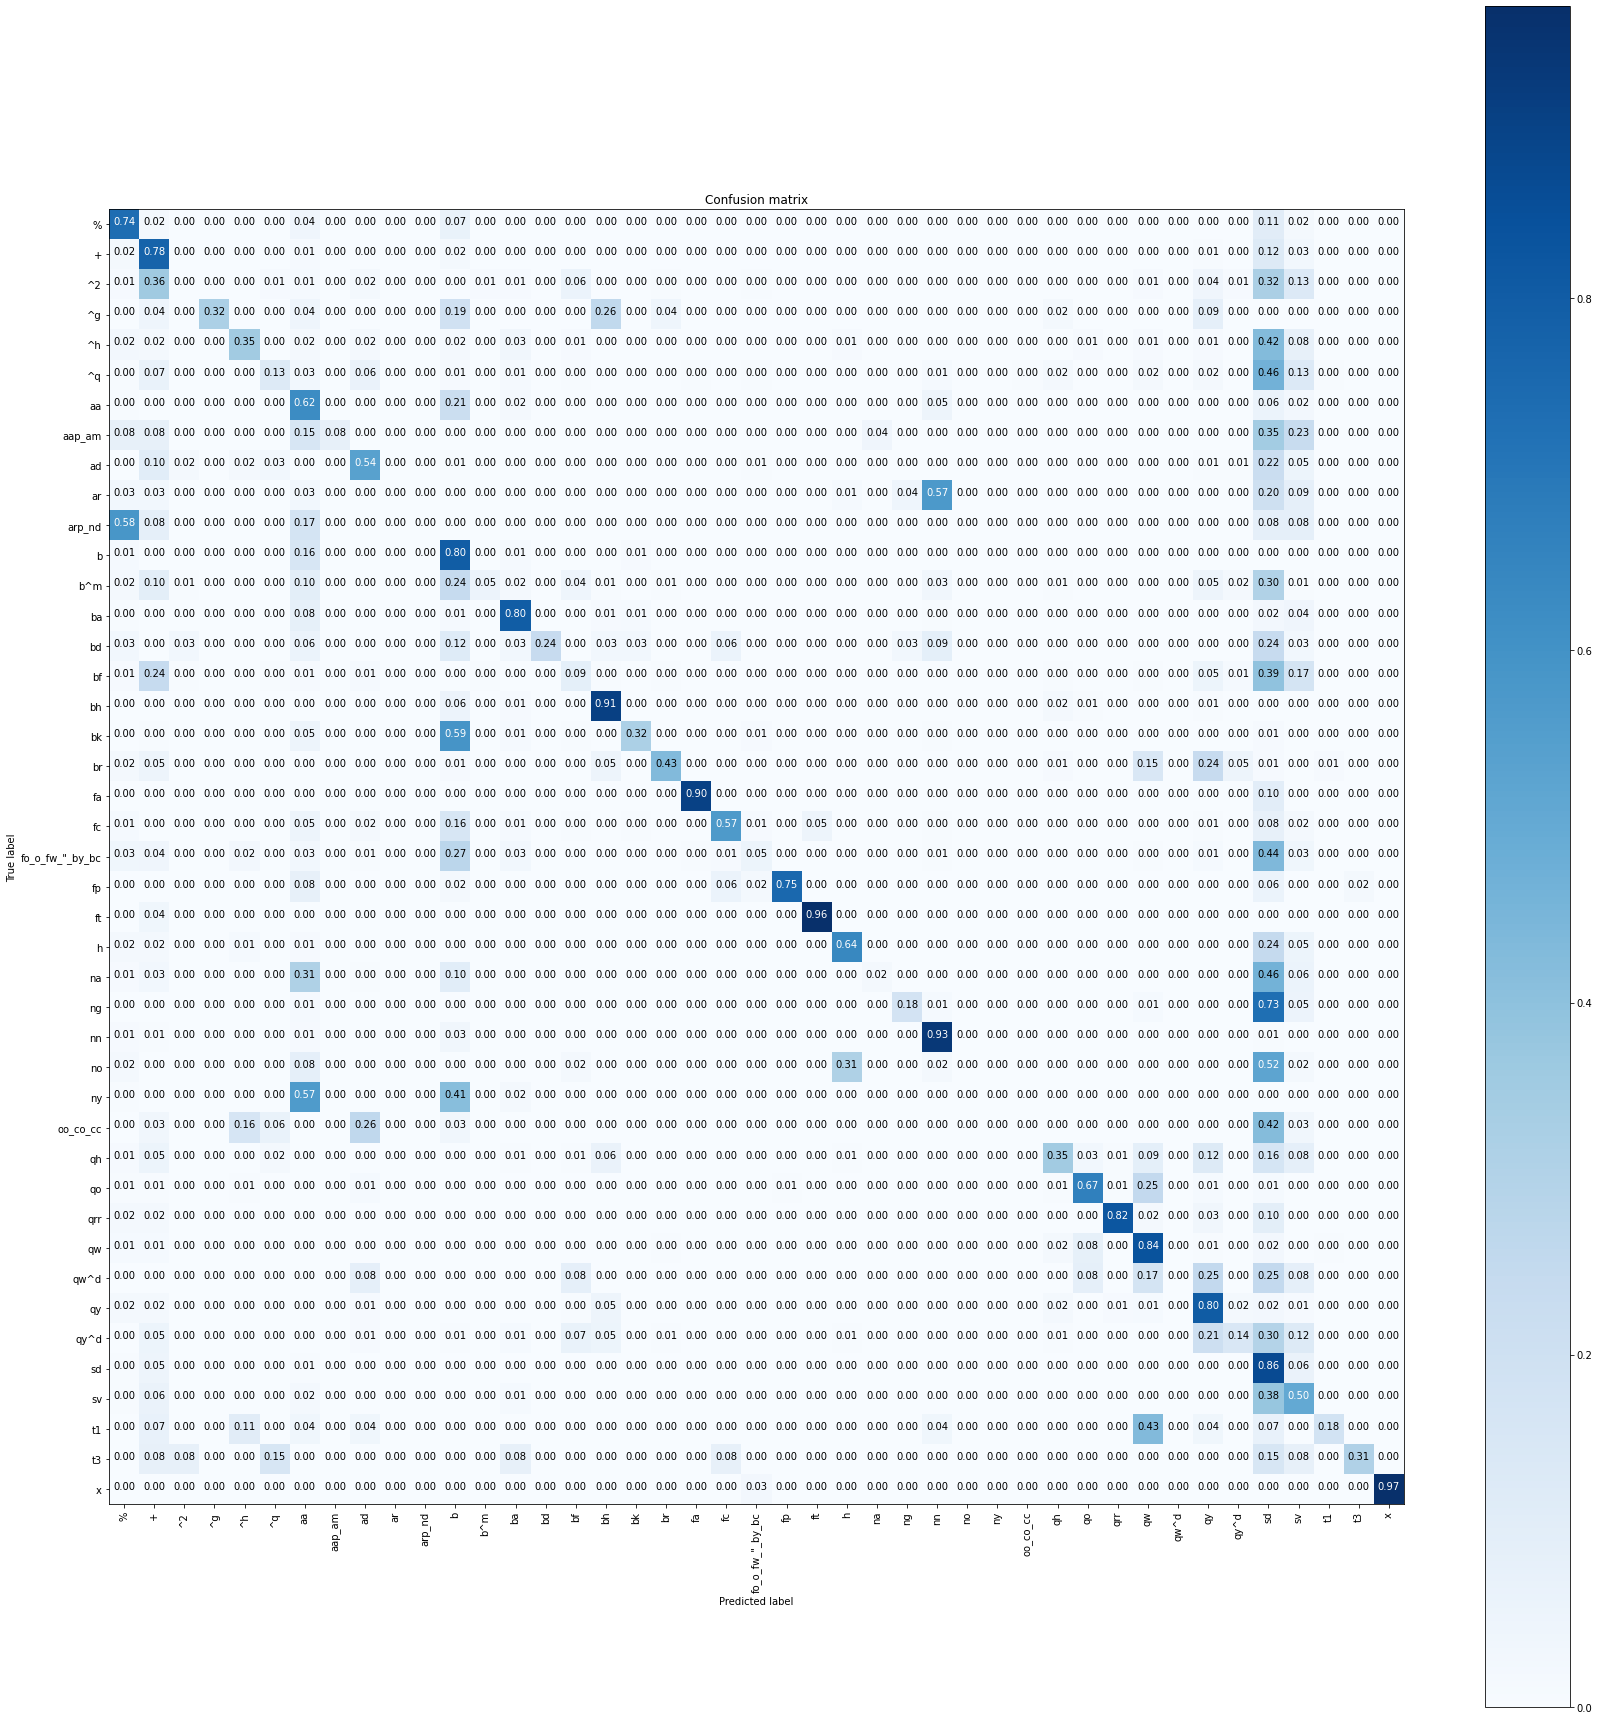

In [ ]:
# Plot normalized confusion matrix
cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
# https://stackoverflow.com/a/50977153/4414156
fig = plt.figure()
fig.set_size_inches(24, 24, forward=True)
plt.imshow(np.nan_to_num(cnf_matrix) , interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

thresh = cnf_matrix.max() / 2.
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, format(cnf_matrix[i, j], '.2f'),
                horizontalalignment="center",
                color="white" if cnf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Minority Class

In [ ]:
# Calculate Accuracies for "br" and "bf"
for i,j in zip(classes,cnf_matrix.diagonal()):
    if i=='br' or i=='bf':
        print(i,j)

bf 0.13855421686746988
br 0.7230769230769231


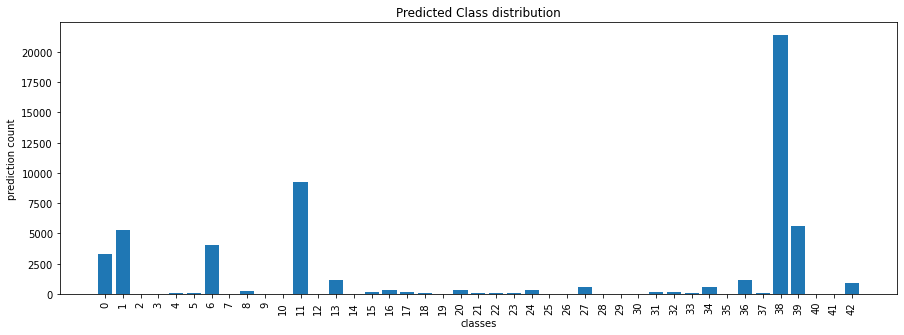

Randomly picking few Testing instances :  [43680, 52946, 25149]
Randomly picking few Testing instances :  [5046, 5740, 14108]


,row,text,true_y,pred_y
0,39683,{C and } I think [ they really + <lipsmack> ...,sv,%
1,11471,{F Oh } my gosh. /,ba,ba
2,44566,"It's interesting, isn't it? /",qy,qy
3,4197,"Take,",fc,fc
4,21049,that was part of Skip Bayless' argument. /,sd,sd
5,3452,"It had held onto a small portion, /",sd,sd


In [ ]:
# br_class_test,br_class_pred
lists = sorted(Counter(list(pred_1d)).items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
ind = np.arange(43)
fig = plt.figure()
fig.set_size_inches(15, 5, forward=True)
plt.title("Predicted Class distribution")
plt.xticks(ind, (range(43)), rotation=90)
plt.xlabel("classes")
plt.ylabel("prediction count")
plt.bar(x,y)
plt.show()
minority_classes = [ k for k, v in sorted(Counter(list(pred_1d)).items(), key=lambda item: item[1])][-6:-4] 
minority_classes.sort()
analysis = []
row_indices = []
for i in minority_classes:
    br_class_test = set(np.where(test_1d == i)[0].tolist())
    br_class_pred = set(np.where(pred_1d == i)[0].tolist())
    row_ind = br_class_test.intersection(br_class_pred)
    row_ind = random.sample(list(row_ind), 3)
    row_indices.extend(row_ind)
    print("Randomly picking few Testing instances : ", list(row_ind))
    if list(row_ind):
        for j in list(row_ind):
            analysis.append([j,reduced_df.iloc[train.shape[0]+j].text,reduced_df.iloc[train.shape[0]+j].act_tag,act_seq[pred_1d[j]]])

analysis = pd.DataFrame(analysis,columns=['row','text','true_y','pred_y'])
analysis

From the confusion matrix we can see that the BERT has performed well on minority class as well as majority class. It has acheived an overall accuracy of 73% and minority class br 46% and bf 8%. 

We can also see from the overall accuracy score and minority class accuracy scores that BERT has given meaningful contextual information for LSTM to get trained properly. 

The last table presents some of the errors encountered during this Model evaluation. We see some of the minority class being miss-classified as usual but this trend is less than in other models such as "sv" but other classes are well classifed. 